# Let's code!

## Import modules

In [ ]:
# OS command
import os

# Sure, we need `pandas`
import pandas as pd
import numpy as np
# Typing
from typing import (
    List,
    Tuple
)
import re
import networkx.algorithms.isomorphism as iso

# Abstract classes we're going to use them  in the section
from abc import ABC, abstractmethod
from itertools import combinations
# Base model
from pydantic import BaseModel
from IPython.display import display
from tqdm import tqdm
from functional_group import get_FG
import networkx as nx

## Abstract Adapter

In [ ]:
class AbstractAdapter(ABC):
    @abstractmethod
    def extract(self):
        """
        Extract input data
        """

    def tranform(self):
        """
        Tranformed data into desired format
        """

    def load(self):
        """
        Load data to next step
        """

    @abstractmethod
    def apply(self):
        """
        Apply data ETL process
        """
        pass


Abstract class ข้างบนจะบอก adapter process โดยภาพรวมนะครับ โดยผมเขียนให้อยู่ในรูปของ ETL เพื่อให้เข้ากับหลัก Data engineer

## CIF Adapter

### Adapter desired output

In [ ]:
class CIF2PandasAdapterOutput(BaseModel):
    """
    Set up desired output
    """
    
    metadata: pd.DataFrame
    loops: List[pd.DataFrame]

    class Config:
        """
        Set some config to allow pd.DataFrame to BaseModel
        """
        arbitrary_types_allowed = True

### Set up adapter

In [ ]:
class CIF2PandasAdapter(AbstractAdapter):
    """
    An adapter to convert CIF into Pandas DataFrames
    """

    @staticmethod
    def load_cif(cif_filepath: str) -> List[str]:
        """
        Read CIF file as String and split looping sections
        """
        with open(cif_filepath) as f:
            filename = f.readline().strip()
            dataframes = []
            dataframe = []
            for line in f.readlines():
                columns = [
                    l.strip() for l in line.strip().split(" ") if l and (l != "")
                ]
                if columns:
                    if columns[0] == "loop_":
                        dataframes.append(dataframe)
                        dataframe = []
                    else:
                        if "fapswitch" not in columns and columns != [""]:
                            dataframe.append(columns)
            dataframes.append(dataframe)

        return dataframes

    @staticmethod
    def get_metadata(dataframes: List[List[str]]) -> pd.DataFrame:
        """
        Get metadata of a CIF file
        """
        return pd.DataFrame(dataframes[0])

    @staticmethod
    def get_loops(dataframes: List[List[str]]) -> List[pd.DataFrame]:
        """
        Get loops
        """
        loops = []
        for dataframe in dataframes[1:]:
            loop = pd.DataFrame(dataframe)
            loop_fixed = loop[loop[1].notna()]
            loop_fixed.columns = loop[loop[1].isna()][0]
            loops.append(loop_fixed)

        return loops

    def extract(self, cif_filepath: str) -> List[str]:
        """
        Read filepath and return sectioned string
        """
        return self.load_cif(cif_filepath)

    def transform(self, cif_list: List[str]) -> Tuple[pd.DataFrame, List[pd.DataFrame]]:
        """
        Transform CIF text into datafram
        :params:
        cif_list: List of sectioned CIF text
        :return:
        Tuple of :
        (
            dataframe of CIF metadata,
            Tuple of (
                dataframe of loop_1,
                dataframe of loop_2,
            )
        )
        """
        metadata = self.get_metadata(cif_list)
        extract_loops = self.get_loops(cif_list)
        return metadata, extract_loops

    def load(
        self, metadata: pd.DataFrame, extract_loops: List[pd.DataFrame]
    ) -> CIF2PandasAdapterOutput:
        """
        Load tranformed data into desired output
        """
        output = CIF2PandasAdapterOutput(metadata=metadata, loops=extract_loops)
        return output

    def apply(self, cif_filepath: str) -> List[pd.DataFrame]:
        """
        Apply ETL pipeline
        """
        # Extract
        cif_list = self.extract(cif_filepath)

        # Transform
        metadata = self.get_metadata(cif_list)
        extract_loops = self.get_loops(cif_list)

        # Load
        output = self.load(metadata, extract_loops)

        return output

## get most negative charge 

In [ ]:
df_train = pd.read_csv('D:/Data/tmlcc-2021/train_clean_no_outlier_01-10.csv')
df_train['surface_area [m^2/g]'].replace(0,np.nan,inplace = True)
df_train.dropna(inplace = True)
df_train.reset_index(drop = True,inplace = True)
df_test = pd.read_csv('D:/Data/tmlcc-2021/test_set_clean_04-10.csv')
FG = list(df_train['functional_groups 1'].unique())


In [ ]:
df_test

,MOFname,volume [A^3],weight [u],density [g/cm3],Di-LCD [A],Df-PLD [A],Dif [A],surface_area [m^2/g],void_volume [cm^3/g],calc_void fraction,...,organic_linker2,topology,CO2/N2_selectivity,heat_adsorption_CO2_P0.15bar_T298K [kcal/mol],_cell_length_a,_cell_length_b,_cell_length_c,_cell_angle_alpha,_cell_angle_beta,_cell_angle_gamma
0,mof_unit_68614,1208.301332,797.70936,1.096247,4.85458,3.79493,4.79015,586.54,0.1039,0.113900,...,26,pcu,36.639791,7.005640,7.806778,9.084327,17.070225,89.170193,86.574021,90.255496
1,mof_unit_68615,4126.414623,3733.65779,1.502452,6.79285,5.32349,6.53826,852.49,0.1422,0.213649,...,17,acs,18.390691,5.119399,12.951336,13.273001,27.655520,94.918678,90.193233,119.264951
2,mof_unit_68616,1602.148373,747.21048,0.774425,6.62995,4.73510,6.62995,3155.73,0.4375,0.338811,...,17,pcu,13.062850,5.045400,14.948982,10.697065,10.019137,89.936295,90.226349,90.052169
3,mof_unit_68617,2436.629312,995.80232,0.678614,7.55453,5.80773,7.55453,3521.09,0.5963,0.404657,...,28,pcu,9.601198,5.106238,10.835044,9.587345,23.461267,89.700303,91.133217,89.959706
4,mof_unit_68618,3123.418006,1337.53800,0.711074,9.90620,7.59386,9.90620,2678.46,0.5479,0.389598,...,19,pcu,12.974954,5.287639,11.498125,16.343084,16.653784,86.935117,91.621359,90.939612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,mof_unit_85609,32660.944605,4723.68288,0.240155,18.67734,14.68097,18.66120,5720.14,3.2318,0.776132,...,14,nbo,4.536626,3.146698,44.634366,38.924145,21.601534,89.675598,60.492060,89.867005
16996,mof_unit_85610,5070.998617,1499.13262,0.490891,14.82749,9.48698,14.73181,4017.28,1.2058,0.591917,...,11,nbo,6.745508,3.658871,18.653876,18.775583,18.721517,109.201102,109.364607,109.469182
16997,mof_unit_85611,4669.804446,1322.04892,0.470097,14.50556,8.17067,14.50528,4288.76,1.1689,0.549497,...,23,pcu,4.666206,3.593052,17.736994,16.514905,15.943922,89.977454,90.891096,89.990901
16998,mof_unit_85612,4682.120862,1213.51148,0.430368,14.63656,10.28172,14.63418,4331.86,1.4091,0.606432,...,25,pcu,4.823305,3.454497,15.773696,17.587298,16.887609,90.057840,90.047571,91.973794


## reordering FG 1, 2 to unique key (train&test)

In [ ]:
order_FG = set()
for x,y in zip(df_train['functional_groups 1'].tolist(),df_train['functional_groups 2'].tolist()):
    k = sorted([x,y])
    order_FG.add((k[0],k[1]))

In [ ]:
fgs = []
for x,y in zip(df_train['functional_groups 1'].tolist(),df_train['functional_groups 2'].tolist()):
    if (x,y) not in order_FG:
        fgs.append([y,x])
    else:
        fgs.append([x,y])
fgs = pd.DataFrame(fgs,columns = ['order_FG-1','order_FG-2'])
df_train = df_train.join(fgs)

In [ ]:
fgs = []
for x,y in zip(df_test['functional_groups 1'].tolist(),df_test['functional_groups 2'].tolist()):
    if (x,y) not in order_FG:
        fgs.append([y,x])
    else:
        fgs.append([x,y])
fgs = pd.DataFrame(fgs,columns = ['order_FG-1','order_FG-2'])
df_test = df_test.join(fgs)

In [ ]:
fgs

,order_FG-1,order_FG-2
0,H,OEt
1,H,I
2,CN,OH
3,H,OMe
4,NO2,Pr
...,...,...
16995,NO2,OH
16996,Me,OMe
16997,CN,Me
16998,HCO,OH


## mapping function 

In [ ]:
map_bond ={
    'S':1,
    'D':2,
    'T':3,
    'A':4,
}
atoms = [
    'Br','C','H','F','N','S','I','Cl','O'
]
atoms2idx = {x:idx for idx,x in enumerate(atoms)}

In [ ]:
sequence = {
    'COOH': ['C', 'O', 'O', 'H'],
    'F': ['F'],
    'OMe': ['O', 'C', 'H', 'H', 'H'],
    'H': ['H'],
    'NHMe': ['N', 'H', 'C', 'H', 'H', 'H'],
    'Pr': ['C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
    'NH2': ['N', 'H', 'H'],
    'Br': ['Br'],
    'HCO': ['C', 'H', 'O'],
    'SO3H': ['S', 'O', 'O', 'O', 'H'],
    'Me': ['C', 'H', 'H', 'H'],
    'OEt': ['O', 'C', 'H', 'H', 'C', 'H', 'H', 'H'],
    'Cl': ['Cl'],
    'CN': ['C', 'N'],
    'Et': ['C', 'C', 'H', 'H', 'H', 'H', 'H'],
    'OH': ['O', 'H'],
    'NO2': ['N', 'O', 'O'],
    'OPr': ['O', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'H'],
    'Ph': ['C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H'],
    'I': ['I']
}

In [ ]:
FG2idx = {x:idx for idx,x in enumerate(FG)}
idx2FG = {idx:x for idx,x in enumerate(FG)}

## get most negative charge (train) 

## convert mof to networkx format

In [ ]:
def mof_to_networkx(df_node,df_edge):
    G = nx.Graph()
    node_attrs = []
    for idx, k in enumerate(df_node['_atom_site_type_symbol'].values):
        attrs = {
            'atom':k
        }
        node_attrs.append((idx,attrs))
    list_atom = df_node['_atom_site_label'].tolist()
    edge_attrs = []
    for u,v,bond in zip(df_edge['_geom_bond_atom_site_label_1'].values,df_edge['_geom_bond_atom_site_label_2'].values,\
                   df_edge['_ccdc_geom_bond_type'].values):
        pos_u ,pos_v = list_atom.index(u) , list_atom.index(v)

        attrs = {
            'bond_type':bond
        }
        edge_attrs.append((pos_u,pos_v,attrs))
    G.add_nodes_from(node_attrs)
    G.add_edges_from(edge_attrs)
    return G

## subgraph isomorphism

In [ ]:
def get_mnc(df_node,list_nodes,H= False):
    y = [float(x) for x in df_node['_atom_type_partial_charge'].values[np.array(list_nodes)]]
    if H ==False:    
        return min(y)
    else:
        return max(y)

In [ ]:
def subgraph_matching(G,FG):
    nm = iso.categorical_node_match('atom', 'atom')
    em = iso.categorical_edge_match('bond','bond')
    GM = nx.algorithms.isomorphism.GraphMatcher(G,FG,node_match =nm, edge_match = em)
    subgraphs = set()
    for g_sub in GM.subgraph_isomorphisms_iter():
        list_node = sorted([k for k,v in g_sub.items()])
        subgraphs.add(tuple(list_node))
    return subgraphs

## train

In [ ]:
root_path = 'D:/Data/tmlcc-2021/mof_cif_train'

In [ ]:
feats = []
for i in tqdm(range(len(df_train))):
    fg1 = df_train.iloc[i]['order_FG-1']
    fg2 = df_train.iloc[i]['order_FG-2']
    name = df_train.iloc[i]['MOFname']+'.cif'
    metal = df_train.iloc[i]['metal_linker']
    ## read cif
    adapter = CIF2PandasAdapter()
    output = adapter.apply(os.path.join(root_path,name))
    ## load FG
    FG1 = get_FG(fg1)
    FG2 = get_FG(fg2)
    ## convert to pandas 
    df_node = output.loops[0].reset_index(drop = True)
    df_edge = output.loops[1].reset_index(drop = True)
    ## convert mof to networkx
    G = mof_to_networkx(df_node,df_edge)
    
    mnc_1 = []
    mnc_2 = []
    
    ## graph matching FG1 
    sub_FG_1 = subgraph_matching(G,FG1)
    for sub in sub_FG_1:
        flag = False
        if fg1 =='H':
            flag = True
        mnc_1.append(get_mnc(df_node,list(sub),flag))
        
    ## graph matching FG2
    sub_FG_2 = subgraph_matching(G,FG2)
    for sub in sub_FG_2:
        flag = False
        if fg2 =='H':
            flag = True
        mnc_2.append(get_mnc(df_node,list(sub),flag))
        
    ## store value
    if not mnc_1 :
        num_mnc_1 = 0
        mean_mnc_1 = 0
    else:
        num_mnc_1 =np.mean(mnc_1)
        mean_mnc_1 = len(mnc_1)
    if not mnc_2 :
        num_mnc_2 = 0
        mean_mnc_2 = 0
    else:
        num_mnc_2 =np.mean(mnc_2)
        mean_mnc_2 = len(mnc_2)
        
    feat = [num_mnc_1,mean_mnc_1,num_mnc_2,mean_mnc_2]
    feats.append(feat)

100%|████████████████████████████████████████████████████████████████████████████| 56737/56737 [24:35<00:00, 38.45it/s]


## count H

In [ ]:
most_negative= pd.DataFrame(feats,columns = ['num_fg-1','mnc_fg-1','num_fg-2','mnc_fg-2'])
most_negative.head(10)

,num_fg-1,mnc_fg-1,num_fg-2,mnc_fg-2
0,-0.701340,11,-0.595762,11
1,-0.790911,2,-0.532949,2
2,0.131734,28,-0.531874,1
3,-0.420022,2,-0.915682,4
4,0.098147,69,-0.479647,5
5,-0.482398,2,0.197268,4
6,0.129622,18,-0.497214,1
7,-0.748884,14,-0.753621,6
8,0.151795,18,-0.493634,2
9,-0.627074,4,-0.391728,1


## count H with C

In [ ]:
most_negative= pd.DataFrame(feats,columns = ['num_fg-1','mnc_fg-1','num_fg-2','mnc_fg-2'])
most_negative.head(10)

,num_fg-1,mnc_fg-1,num_fg-2,mnc_fg-2
0,-0.701340,11,-0.595762,11
1,-0.790911,2,-0.532949,2
2,0.123086,27,-0.531874,1
3,-0.420022,2,-0.915682,4
4,0.162418,59,-0.479647,5
5,-0.482398,2,0.197268,4
6,0.138665,18,-0.497214,1
7,-0.748884,14,-0.753621,6
8,0.127937,16,-0.493634,2
9,-0.627074,4,-0.391728,1


In [ ]:
#most_negative.to_csv('train_mnc_fg_1.csv',index = False)

## test

In [ ]:
root_path = 'D:/Data/tmlcc-2021/mof_cif_test'

In [ ]:
feats = []
for i in tqdm(range(len(df_test))):
    fg1 = df_test.iloc[i]['order_FG-1']
    fg2 = df_test.iloc[i]['order_FG-2']
    name = df_test.iloc[i]['MOFname']+'.cif'
    metal = df_test.iloc[i]['metal_linker']
    ## read cif
    adapter = CIF2PandasAdapter()
    output = adapter.apply(os.path.join(root_path,name))
    ## load FG
    FG1 = get_FG(fg1)
    FG2 = get_FG(fg2)
    ## convert to pandas 
    df_node = output.loops[0].reset_index(drop = True)
    df_edge = output.loops[1].reset_index(drop = True)
    ## convert mof to networkx
    G = mof_to_networkx(df_node,df_edge)
    
    mnc_1 = []
    mnc_2 = []
    
    ## graph matching FG1 
    sub_FG_1 = subgraph_matching(G,FG1)
    for sub in sub_FG_1:
        flag = False
        if fg1 =='H':
            flag = True
        mnc_1.append(get_mnc(df_node,list(sub),flag))
        
    ## graph matching FG2
    sub_FG_2 = subgraph_matching(G,FG2)
    for sub in sub_FG_2:
        flag = False
        if fg2 =='H':
            flag = True
        mnc_2.append(get_mnc(df_node,list(sub),flag))
        
    if not mnc_1 :
        num_mnc_1 = 0
        mean_mnc_1 = 0
    else:
        num_mnc_1 =np.mean(mnc_1)
        mean_mnc_1 = len(mnc_1)
        
    if not mnc_2 :
        num_mnc_2 = 0
        mean_mnc_2 = 0
    else:
        num_mnc_2 =np.mean(mnc_2)
        mean_mnc_2 = len(mnc_2)
        
    feat = [num_mnc_1,mean_mnc_1,num_mnc_2,mean_mnc_2]
    feats.append(feat)

100%|████████████████████████████████████████████████████████████████████████████| 17000/17000 [07:28<00:00, 37.88it/s]


In [ ]:
most_negative= pd.DataFrame(feats,columns = ['num_fg-1','mnc_fg-1','num_fg-2','mnc_fg-2'])
most_negative.head(10)

,num_fg-1,mnc_fg-1,num_fg-2,mnc_fg-2
0,0.199205,34,-0.755498,6
1,0.161119,21,-0.285686,15
2,-0.184804,6,-0.744747,2
3,0.135468,28,-0.541878,4
4,-0.340827,10,-0.769926,4
5,0.148743,10,0.148743,10
6,-0.646544,5,-0.565045,7
7,-0.676345,4,-0.644549,10
8,0.215627,64,-0.902219,8
9,-0.564665,2,-0.547581,2


In [ ]:
most_negative= pd.DataFrame(feats,columns = ['num_fg-1','mnc_fg-1','num_fg-2','mnc_fg-2'])
most_negative.head(10)

,num_fg-1,mnc_fg-1,num_fg-2,mnc_fg-2
0,0.199205,34,-0.755498,6
1,0.161119,21,-0.285686,15
2,-0.184804,6,-0.744747,2
3,0.135467,28,-0.541878,4
4,-0.340827,10,-0.769926,4
5,0.148743,10,0.148743,10
6,-0.646544,5,-0.565045,7
7,-0.676345,4,-0.644549,10
8,0.215627,64,-0.902219,8
9,-0.564665,2,-0.547581,2


In [ ]:
#most_negative.to_csv('test_mnc_fg_1.csv',index = False)

In [ ]:
nm = iso.categorical_node_match('atom', 'atom')
em = iso.categorical_edge_match('bond','bond')

In [ ]:
GM = nx.algorithms.isomorphism.GraphMatcher(G,FG,node_match =nm, edge_match = em)
for subgraph in GM.subgraph_isomorphisms_iter():
    print(subgraph)

{133: 1, 134: 2, 136: 3, 137: 4, 135: 5}
{133: 1, 134: 2, 136: 3, 135: 4, 137: 5}
{133: 1, 134: 2, 137: 3, 136: 4, 135: 5}
{133: 1, 134: 2, 137: 3, 135: 4, 136: 5}
{133: 1, 134: 2, 135: 3, 136: 4, 137: 5}
{133: 1, 134: 2, 135: 3, 137: 4, 136: 5}
{138: 1, 139: 2, 140: 3, 141: 4, 142: 5}
{138: 1, 139: 2, 140: 3, 142: 4, 141: 5}
{138: 1, 139: 2, 141: 3, 140: 4, 142: 5}
{138: 1, 139: 2, 141: 3, 142: 4, 140: 5}
{138: 1, 139: 2, 142: 3, 140: 4, 141: 5}
{138: 1, 139: 2, 142: 3, 141: 4, 140: 5}
{143: 1, 144: 2, 145: 3, 146: 4, 147: 5}
{143: 1, 144: 2, 145: 3, 147: 4, 146: 5}
{143: 1, 144: 2, 146: 3, 145: 4, 147: 5}
{143: 1, 144: 2, 146: 3, 147: 4, 145: 5}
{143: 1, 144: 2, 147: 3, 145: 4, 146: 5}
{143: 1, 144: 2, 147: 3, 146: 4, 145: 5}
{148: 1, 149: 2, 152: 3, 150: 4, 151: 5}
{148: 1, 149: 2, 152: 3, 151: 4, 150: 5}
{148: 1, 149: 2, 150: 3, 152: 4, 151: 5}
{148: 1, 149: 2, 150: 3, 151: 4, 152: 5}
{148: 1, 149: 2, 151: 3, 152: 4, 150: 5}
{148: 1, 149: 2, 151: 3, 150: 4, 152: 5}
{155: 1, 156: 2,

In [ ]:
print GM = iso.GraphMatcher(B,A,node_match=iso.categorical_node_match(['material', 'size'],['metal',1]))

In [ ]:
G.nodes(data = True)

NodeDataView({0: {'atom': 'P'}, 1: {'atom': 'O'}, 2: {'atom': 'O'}, 3: {'atom': 'O'}, 4: {'atom': 'O'}, 5: {'atom': 'O'}, 6: {'atom': 'O'}, 7: {'atom': 'H'}, 8: {'atom': 'C'}, 9: {'atom': 'H'}, 10: {'atom': 'H'}, 11: {'atom': 'P'}, 12: {'atom': 'P'}, 13: {'atom': 'O'}, 14: {'atom': 'O'}, 15: {'atom': 'O'}, 16: {'atom': 'O'}, 17: {'atom': 'O'}, 18: {'atom': 'C'}, 19: {'atom': 'H'}, 20: {'atom': 'C'}, 21: {'atom': 'H'}, 22: {'atom': 'H'}, 23: {'atom': 'C'}, 24: {'atom': 'C'}, 25: {'atom': 'H'}, 26: {'atom': 'H'}, 27: {'atom': 'H'}, 28: {'atom': 'Ba'}, 29: {'atom': 'C'}, 30: {'atom': 'H'}, 31: {'atom': 'C'}, 32: {'atom': 'H'}, 33: {'atom': 'H'}, 34: {'atom': 'C'}, 35: {'atom': 'H'}, 36: {'atom': 'C'}, 37: {'atom': 'H'}, 38: {'atom': 'H'}, 39: {'atom': 'H'}, 40: {'atom': 'P'}, 41: {'atom': 'O'}, 42: {'atom': 'O'}, 43: {'atom': 'O'}, 44: {'atom': 'O'}, 45: {'atom': 'P'}, 46: {'atom': 'O'}, 47: {'atom': 'O'}, 48: {'atom': 'O'}, 49: {'atom': 'O'}, 50: {'atom': 'Ba'}, 51: {'atom': 'P'}, 52: {'

In [ ]:
GM.mapping

{189: 1, 190: 2, 193: 3, 191: 4, 192: 5}

In [ ]:
subgraphs[153].nodes(data = True)

NodeDataView({0: {'atom': 'P'}, 3: {'atom': 'O'}, 11: {'atom': 'P'}, 109: {'atom': 'C'}, 28: {'atom': 'Ba'}})

In [ ]:
subgraphs[153].edges(data = True)

EdgeDataView([(0, 109, {'bond': 1}), (0, 28, {'bond': 1}), (3, 28, {'bond': 1}), (11, 28, {'bond': 1})])

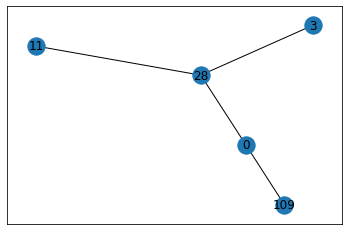

In [ ]:
nx.draw_networkx(subgraphs[153])

In [ ]:
FG.nodes(data = True)

NodeDataView({1: {'atom': 'O'}, 2: {'atom': 'C'}, 3: {'atom': 'H'}, 4: {'atom': 'H'}, 5: {'atom': 'H'}})

In [ ]:
FG.edges(data = True)

EdgeDataView([(1, 2, {'bond_type': 1}), (2, 4, {'bond_type': 1}), (2, 5, {'bond_type': 1}), (2, 3, {'bond_type': 1})])

In [ ]:
nx.is_isomorphic(FG,subgraphs[120],node_match = True , edge_match = True)

False

In [ ]:
test = nx.Graph()
test.add_node(1,atom = 'O')
test.add_node(2,atom = 'H')
test.add_node(3,atom = 'C')
test.add_node(4,atom = 'H')
test.add_node(5,atom = 'H')
#c
test.add_edge(3,1,bond_type=map_bond['S'])
test.add_edge(3,4,bond_type=map_bond['S'])
test.add_edge(3,5,bond_type=map_bond['S'])
test.add_edge(3,2,bond_type=map_bond['S'])

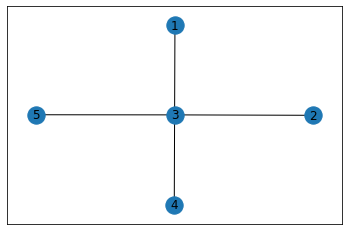

In [ ]:
nx.draw_networkx(test)

In [ ]:
import networkx.algorithms.isomorphism as iso
nm = iso.categorical_node_match('atom', 'atom')
em = iso.categorical_edge_match('bond','bond')

In [ ]:
nx.is_isomorphic(FG,test,node_match = nm , edge_match = em)

True

In [ ]:
import networkx as nx
# ref:https://github.com/maxhodak/keras-molecules/pull/32/files

def mol_to_nx(mol):
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G